# Generate emissions scenarios and run in FaIR

Here, we check that we can reproduce the baseline results of AR6 using SSP2-4.5 in FaIR, and export the emissions scenarios that we want to run our modified scenarios with.

We see that according to UNFCCC NDC Synthesis Report (https://unfccc.int/sites/default/files/resource/cma2021_08_adv_1.pdf), SSP2-4.5 is quite in line with NDC projections to 2030. So, we use this as our baseline scenario.

In [18]:
import copy
import json
from multiprocessing import Pool

import fair
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
with open('../data_input/fair-1.6.2-ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [15]:
df = pd.read_csv('../data_input/ar6/gmst-assessment.csv')
ar6_gmst = df['temperature'].values

In [10]:
emissions_out = {}
results_out = {}

## transition from historical to SSP projections

We use the same method as in AR6 to transition from updated historical observations up to 2019 and SSP scenarios that start in 2014.

See https://github.com/chrisroadmap/ar6/blob/main/notebooks/080_chapter7_AR6_ERF.ipynb

In [3]:
emissions = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-world-ssp245-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO',
        'Emissions|CO2': 'CO2'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-world-ssp245-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
#        (emissions_old.Variable=='Emissions|CO2|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO', 'CO2']:
    df = pd.read_csv(
        '../data_input/ceds-20210421/{}_global_CEDS_emissions_by_sector_2021_04_21.csv'.format(species)
    )
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions['CO2'] = 0
df_emissions['CO2'] = 0
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,CO2,NH3,NOx,OC,SO2,VOC
year,,,,,,,,
1750,2.096539,348.447580,8.576757,6.656572,12.728669,15.445726,2.293819,60.621604
1751,2.071691,343.846182,8.576757,6.587983,12.585743,15.186770,2.263149,59.690086
1752,2.063075,341.728428,8.580118,6.546281,12.587693,15.032524,2.252466,59.236140
1753,2.070710,343.594444,8.580118,6.607197,12.533225,15.180589,2.266458,59.632675
1754,2.098107,349.734192,8.583478,6.739907,12.630225,15.556812,2.318330,60.878454
...,...,...,...,...,...,...,...,...
2015,7.772863,891.122622,34501.857574,63.079885,138.550976,28.997895,94.125586,212.244598
2016,7.665941,871.973336,34493.063227,63.683214,136.836545,28.965911,90.351628,211.242927
2017,7.657160,863.791831,34985.111571,64.349705,136.619149,28.912940,87.109098,211.172681


## convenience function for running FaIR config with each emission species

In [28]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

def fair_process(emissions):
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = emissions
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
    #    updated_config[i]["scale"][43] = 0.6
        updated_config[i]["F_solar"][270:] = 0
    
    if __name__ == '__main__':
        with Pool(3) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    
    return c, temp_rebase, f_ant, f_aer, f_tot

## Run SSP2-4.5 emissions driven in AR6 config

In [4]:
scenarios = ["ssp245"]

In [5]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-world-ssp245-v5-1-0.csv')
years = np.arange(1750, 2111)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

for scenario in scenarios:
    emissions_out[scenario] = np.ones((361, 40)) * np.nan
    emissions_out[scenario][:,0] = years

    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        emissions_out[scenario][:first_row,i+1] = ssp_df.loc[
            (ssp_df['Model']=='MESSAGE-GLOBIOM')&
            (ssp_df['Region']=='World')&
            (ssp_df['Scenario']=='ssp245')&
            (ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[
            (ssp_df['Model']=='MESSAGE-GLOBIOM')&
            (ssp_df['Region']=='World')&
            (ssp_df['Scenario']=='ssp245')&
            (ssp_df['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
        emissions_out[scenario][first_row:(last_row+1), i+1] = f(
            np.arange(first_scenyear, last_scenyear+1)
        )*unit_convert[i+1]
    
    # fill in history
    emissions_out[scenario][:265,1] = emissions_ceds_update.loc[:2014,'CO2'] * unit_convert[1]
    emissions_out[scenario][:265,5] = emissions_ceds_update.loc[:2014,'SO2'] * unit_convert[5]
    emissions_out[scenario][:265,6] = emissions_ceds_update.loc[:2014,'CO']
    emissions_out[scenario][:265,7] = emissions_ceds_update.loc[:2014,'VOC']
    emissions_out[scenario][:265,8] = emissions_ceds_update.loc[:2014,'NOx'] * unit_convert[8]
    emissions_out[scenario][:265,9] = emissions_ceds_update.loc[:2014,'BC']
    emissions_out[scenario][:265,10] = emissions_ceds_update.loc[:2014,'OC']
    emissions_out[scenario][:265,11] = emissions_ceds_update.loc[:2014,'NH3']
    
    emissions_out[scenario][265:270,1] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO2'].values * unit_convert[1] + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,1]
    emissions_out[scenario][265:270,9] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'BC'].values + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,9]
    emissions_out[scenario][265:270,10] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'OC'].values + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,10]
    emissions_out[scenario][265:270,5] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'SO2'].values * unit_convert[5] + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,5]
    emissions_out[scenario][265:270,11] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NH3'].values + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,11]
    emissions_out[scenario][265:270,8] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'NOx'].values  * unit_convert[8] + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,8]
    emissions_out[scenario][265:270,7] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'VOC'].values + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,7]
    emissions_out[scenario][265:270,6] = np.linspace(1,0.2,5) * emissions_ceds_update.loc[2015:2019,'CO'].values + np.linspace(0,0.8,5) * emissions_out[scenario][265:270,6]
    
#    # use constant 2019 emissions for 2020 and 2021
#    emissions_out[scenario][270:272,1:] = emissions_out[scenario][269,1:]

Text(0, 0.5, 'relative units, year 2020 = 100')

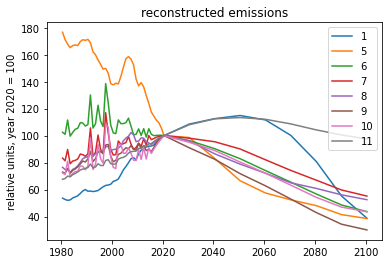

In [6]:
for specie_index in [1, 5, 6, 7, 8, 9, 10, 11]:
    pl.plot(
        np.arange(1980.5, 2101),
        100 * emissions_out[scenario][230:351, specie_index] / emissions_out[scenario][270, specie_index],
        label=specie_index,
    )
pl.legend()
pl.title('reconstructed emissions')
pl.ylabel('relative units, year 2020 = 100')

In [7]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = emissions_out[scenario]
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
#    updated_config[i]["scale"][43] = 0.6
    updated_config[i]["F_solar"][270:] = 0

In [8]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(3) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|███████████████████████████████████████| 2237/2237 [03:23<00:00, 10.98it/s]


In [9]:
result_t = np.array(result).transpose(1,2,0)

In [11]:
results_out[scenario] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out[scenario]['co2_conc'] = c
results_out[scenario]['temp'] = temp_rebase
results_out[scenario]['F_ant'] = f_ant
results_out[scenario]['F_aer'] = f_aer
results_out[scenario]['F_tot'] = f_tot

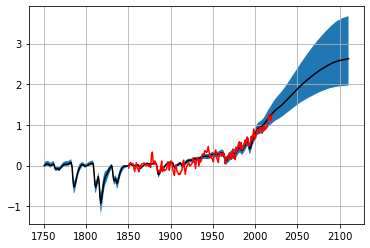

In [16]:
pl.fill_between(np.arange(1750.5,2111), np.percentile(results_out[scenario]['temp'], 5, axis=1), np.percentile(results_out[scenario]['temp'], 95, axis=1))
pl.plot(np.arange(1750.5,2111), np.percentile(results_out[scenario]['temp'], 50, axis=1), color='k')
pl.plot(np.arange(1850.5, 2021), ar6_gmst, color='r')

pl.grid()

In [17]:
emissions_out

{'ssp245': array([[ 1.75000000e+03,  2.33911547e-03,  8.11267109e-02, ...,
          0.00000000e+00,  1.05087730e+02,  4.27574490e+03],
        [ 1.75100000e+03,  2.33911547e-03,  8.26192087e-02, ...,
          0.00000000e+00,  1.05107200e+02,  4.27676850e+03],
        [ 1.75200000e+03,  2.34003205e-03,  8.41391642e-02, ...,
          0.00000000e+00,  1.05125020e+02,  4.27770490e+03],
        ...,
        [ 2.10800000e+03,  3.73923069e+00, -1.09965400e+00, ...,
          7.66800000e-03,  1.07602299e+02,  4.36670685e+03],
        [ 2.10900000e+03,  3.71289808e+00, -1.07347176e+00, ...,
          7.61400000e-03,  1.06844536e+02,  4.33595539e+03],
        [ 2.11000000e+03,  3.68656547e+00, -1.04728952e+00, ...,
          7.56000000e-03,  1.06086773e+02,  4.30520393e+03]])}

## 50% methane reduction in 2030 

We will use SSP2-4.5 as a baseline and assume a linear decline 2020 to 2030, with 50% below SSP2-4.5 values in all future years.

- 380 MtCH4/yr as "business as usual" in 2030 in ETC Keeping 1.5C Alive
- 382 MtCH4/yr in 2030 in SSP2-4.5

In [26]:
emissions_out['ch4_50'] = copy.copy(emissions_out['ssp245'])

emissions_out['ch4_50'][280:,3] = emissions_out['ch4_50'][280:,3] * 0.5
emissions_out['ch4_50'][270:281,3] = np.linspace(1,0,11)*emissions_out['ch4_50'][270,3] + np.linspace(0,1,11)*emissions_out['ch4_50'][280,3]

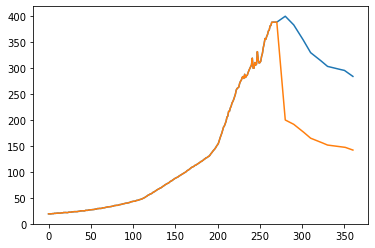

In [27]:
pl.plot(emissions_out['ssp245'][:,3])
pl.plot(emissions_out['ch4_50'][:,3])

In [29]:
results_out['ch4_50'] = {}
(
    results_out['ch4_50']['co2_conc'],
    results_out['ch4_50']['temp'],
    results_out['ch4_50']['F_ant'],
    results_out['ch4_50']['F_aer'],
    results_out['ch4_50']['F_tot']
) = fair_process(emissions_out['ch4_50'])

100%|███████████████████████████████████████| 2237/2237 [03:07<00:00, 11.93it/s]


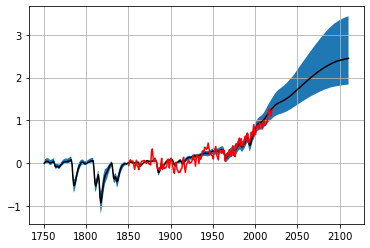

In [31]:
pl.fill_between(np.arange(1750.5,2111), np.percentile(results_out['ch4_50']['temp'], 5, axis=1), np.percentile(results_out['ch4_50']['temp'], 95, axis=1))
pl.plot(np.arange(1750.5,2111), np.percentile(results_out['ch4_50']['temp'], 50, axis=1), color='k')
pl.plot(np.arange(1850.5, 2021), ar6_gmst, color='r')

pl.grid()

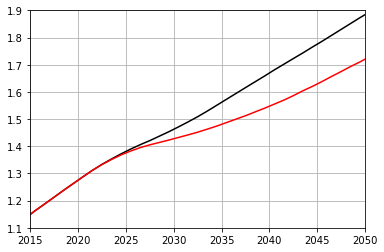

In [42]:
pl.plot(np.arange(1750.5,2111), np.percentile(results_out['ssp245']['temp'], 50, axis=1), color='k')
pl.plot(np.arange(1750.5,2111), np.percentile(results_out['ch4_50']['temp'], 50, axis=1), color='r')
pl.xlim(2015, 2050)
pl.ylim(1.1, 1.9)
pl.grid()

## Halting deforestation in 2022

Easiest to set land use CO2 emissions to zero in 2022. This might be an overall warming with respect to SSP2-4.5, because of the assumption that land use forcing scales with cumulative land use CO2.

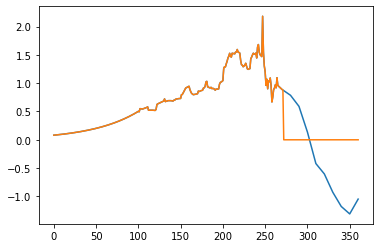

In [38]:
emissions_out['co2afolu_0'] = copy.copy(emissions_out['ssp245'])
emissions_out['co2afolu_0'][272:,2] = 0
pl.plot(emissions_out['ssp245'][:,2])
pl.plot(emissions_out['co2afolu_0'][:,2])

In [39]:
results_out['co2afolu_0'] = {}
(
    results_out['co2afolu_0']['co2_conc'],
    results_out['co2afolu_0']['temp'],
    results_out['co2afolu_0']['F_ant'],
    results_out['co2afolu_0']['F_aer'],
    results_out['co2afolu_0']['F_tot']
) = fair_process(emissions_out['co2afolu_0'])

100%|███████████████████████████████████████| 2237/2237 [02:53<00:00, 12.86it/s]


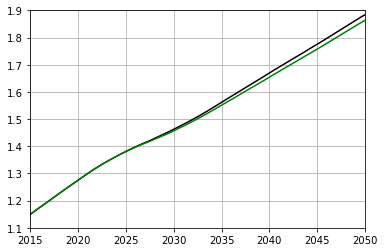

In [41]:
pl.plot(np.arange(1750.5,2111), np.percentile(results_out['ssp245']['temp'], 50, axis=1), color='k')
pl.plot(np.arange(1750.5,2111), np.percentile(results_out['co2afolu_0']['temp'], 50, axis=1), color='g')
pl.xlim(2015, 2050)
pl.ylim(1.1, 1.9)
pl.grid()

## Coal phase out by 2030

this will be a little more difficult, and requires us to go back to the IIASA Scenario Database to estimate the coal-attributable emissions. Luckily for us, which makes it easy, in SSP2-4.5 coal consumption is pretty flat from 2020 to 2030.

We assume simply that coal is replaced by renewables, so zero carbon.

In [56]:
iea_emis_df = pd.read_csv('../data_input/iea/emissions.csv')
iea_prod_df = pd.read_csv('../data_input/iea/production.csv')

In [59]:
coal_co2 = iea_emis_df.loc[
    (iea_emis_df['PRODUCT']=='COAL')&
    (iea_emis_df['GAS']=='CO2'),
    'Value'
].values[0]  # ktCO2
coal_co2

14797529.4

In [60]:
coal_prod = iea_prod_df.loc[
    (iea_prod_df['PRODUCT']=='COAL'),
    'Value'
].values[0]  # TJ
coal_prod

167294072.7

In [61]:
coal_co2/coal_prod 
# ktCO2/TJ = kgCO2/MJ : if this looks low, it's because we are used to seeing kgCO2/kWh electricity.
# In a coal plant, efficiency is about 35%, and there are 3.6 MJ in 1 kWh, so we have (cell below)

0.08845220372233786

In [62]:
coal_co2/coal_prod / 0.35 * 3.6  # kgCO2/kWh electricity

0.909794095429761

In [63]:
coal_ch4 = iea_emis_df.loc[
    (iea_emis_df['PRODUCT']=='COAL')&
    (iea_emis_df['GAS']=='CH4'),
    'Value'
].values[0]  # ktCH4
coal_ch4

34051.0

In [65]:
coal_ch4/coal_prod  # though does this include fugitive? I believe so.

0.0002035397874559605

In [ ]:
# what about SO2